# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn import datasets

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



Whenever you look at some source of data which somehow has the form of $\textit{clusters}$ in a d-dimensional input space. Our goal will be to identify the clusters and find a representative mean-value.

In the simple k-mean algorithm the number of Clusters **K** should be choosen in advantage and the partition of the data points into sets will be done by minimization of the total sum of squared distances from each point to the mean of its assigned cluster.

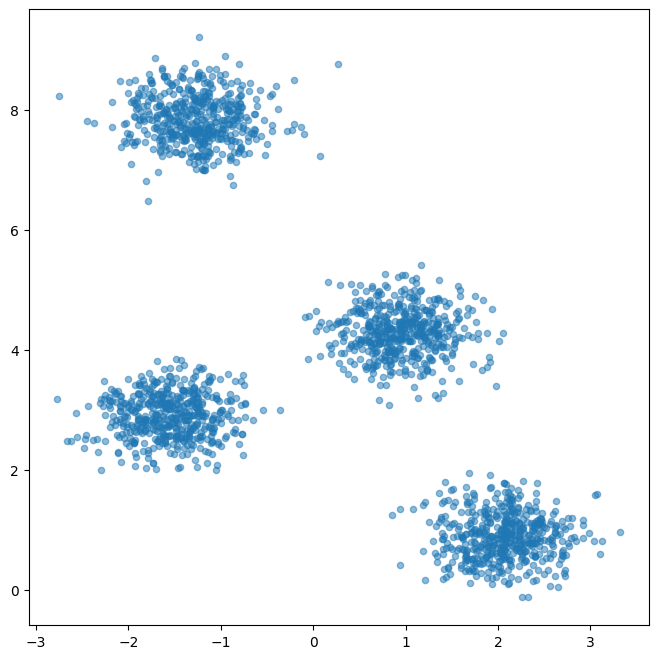

In [2]:
def get_data(n_samples=2000, n_clusters=4, cluster_std=.4, rs=0):
    return datasets.make_blobs(n_samples=n_samples, centers=n_clusters, cluster_std=cluster_std, random_state=rs)[0]

X = get_data()
plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], alpha = 0.5, s=20)
plt.show()

> **Based on the template below. Implement the k-mean algorithm which contains following steps**
>
> - Assign each Point to the mean to which it is closest.
> - If point's assignments has changed, recompute the mean of each cluster
> - If no point's assignments has changed, stop and keep the clusters
> - calculate decision boundaries
> - Plot the data, Cluster Mean-Values and (optional) decision Boundaries

In [3]:
class KMeans:
    def __init__(self, n_clusters=3, max_iteration=20, random_seed=0):
        """Init k-means algorithm.

        Args:
            n_clusters (int): Assumed number of clusters.
            max_iteration (int): Maximum number of iterations.
        """
        self.n_clusters = n_clusters
        self.max_iteration = max_iteration
        self.random_seed = random_seed

    def _get_initial_center(self, X):
        """Initialize the centers.

        Args:
            n_dim (int): Dimensionality of the input samples.

        Returns:
            ndarray: A (n_cluster, n_dim) shaped array which represent the initial centers.

        """
        random.seed(self.random_seed)
        n_samples = X.shape[0]
        random_idx = random.sample(range(n_samples), self.n_clusters)
        centers = X[random_idx]
        return centers

    def _get_initial_center_problem(self, X):
        return np.array([[0.01, 5], [0.0, 5.2], [0, 4.9]])

    def _dist(self, X):
        """Compute a distance matrix between centers and datapoints based on the
            squared euclidean distance.

        Args:
            X (ndarray): Input samples.

        Returns:
            ndarray: A (n_samples, n_clusters) shaped array representing the distance
                of a sample to a corresponding center.

        """
        D = np.array([np.linalg.norm(X - center, axis=-1) for center in self.centers]).T
        return D

    def fit(self, X):
        """Perform k-means.

        Args:
            X (ndarray): Input samples.

        """
        self.X_ = np.array(X)
        # Init centers
        self.centers = self._get_initial_center(self.X_)

        for _ in range(self.max_iteration):

            # E-Step according to Equation 9.2 in [Bishop2006].
            D = self._dist(self.X_)
            D = np.argmin(D, axis=1)

            # M-step accoding to Equation 9.4 in [Bishop2006].
            self.centers = np.array([np.mean(self.X_[D == k], axis=0) for k in range(self.n_clusters)])

        return self

    def predict(self, X):
        """Calculate closest cluster center.

        Args:
            X (ndarray): Input data.

        Returns
            ndarray: An (n_samples,) shaped array containing cluster indices.

        """
        D = self._dist(X)
        return np.argmin(D, axis=1)


    def plot(self, X):
        """Plot the clustered data with corresponding centers.

        Args:
            X (ndarray): Input samples.

        """
        plt.figure(figsize=(8, 8))
        plt.scatter(X[:,0], X[:,1], c=self.predict(X), alpha = 0.5, s=20)
        plt.scatter(self.centers[:,0], self.centers[:,1], c='red', marker='x', s=100)
        plt.show()

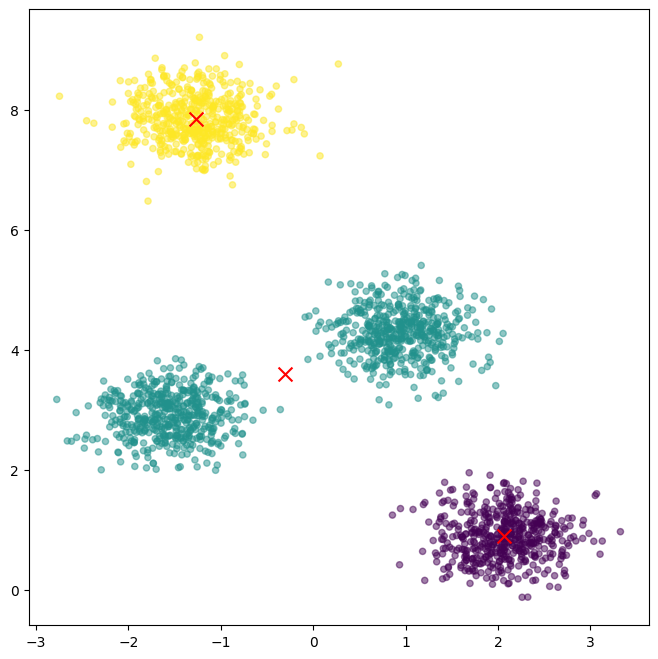

In [4]:
clusterer = KMeans(max_iteration=10)
clusterer.fit(X)
clusterer.plot(X)

In the previous example the choice of $K$ was given by factors outside our control. In general this wont be the case and a reasonable way to choose its value is by plotting the sum of squared errors between each point and the **mean** of its **Cluster**

> Implement a function for plotting the sum of squared errors subject to values for the Parameter $K$.

In [7]:
def mse_cluster(X, k):
    """Compute the distance of all samples to its center and compute its mean.

    Args:
        X (ndarray): Input data.
        k (int): Number of centers.

    """
    new_clusterer = KMeans(n_clusters=k)
    new_clusterer.fit(X)
    
    preds = new_clusterer.predict(X)
    
    dist_to_centers = []
    for i_center, center in enumerate(new_clusterer.centers):
        dist_to_centers.extend(np.sum((X[preds == i_center] - center)**2, -1))
        
    return np.mean(dist_to_centers)

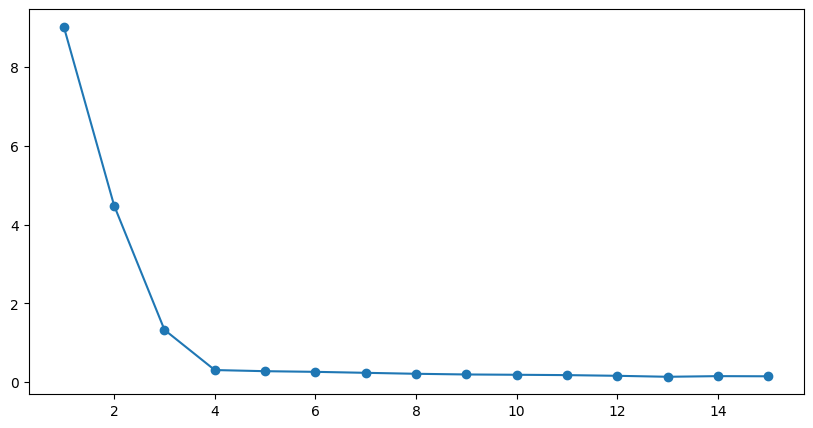

In [9]:
ki = np.arange(15)+1
errors = [mse_cluster(X, k) for k in ki]

plt.figure(figsize=(10,5))
plt.plot(ki, errors, '-o')
plt.show()

## k-Means for Color Compression

One interesting application of clustering is in color compression within images. For example, consider follow Image which is stored as a three-dimensional array of size (height, width, channel) containing red/blue/green contributions as integers from 0 to 255

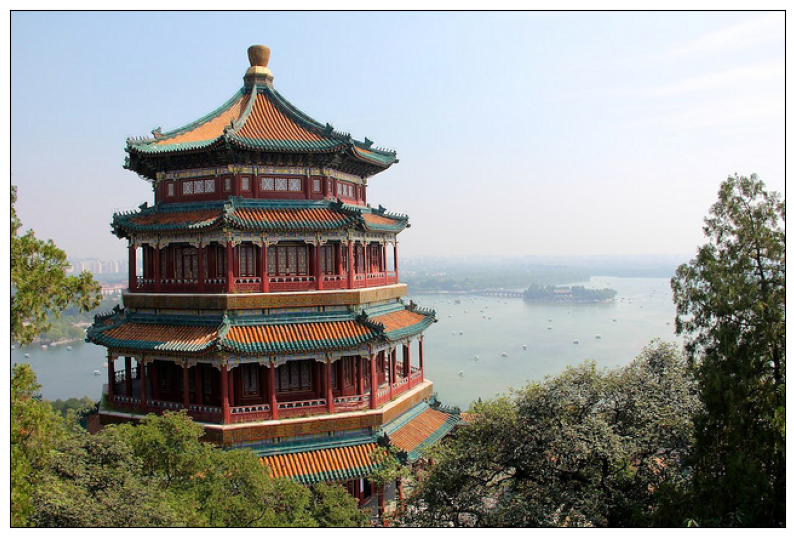

(427, 640, 3)


In [10]:
china = datasets.load_sample_image("china.jpg")
plt.figure(figsize = (10, 10))
plt.axes(xticks=[], yticks=[])
plt.imshow(china)
plt.show()
print(china.shape)

One way we can see this set of pixels is as a cloud of points in a three-dimensional color space.

> Reshape the data to `(n_samples, n_features)` and rescale the color so that they lie between 0 and 1

In [14]:
data = china / 255.0
data = data.reshape(china.shape[0]*china.shape[1], china.shape[2])
data.shape

(273280, 3)

> Use follow function to visualize the pixels in color space.

In [12]:
def plot_pixels(data, title, colors = None, N = 10000):
    if colors is None:
        colors = data

    # Choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].scatter(R, G, color = colors, marker = '.')
    ax[0].set(xlabel = 'Red', ylabel = 'Green', xlim = (0, 1), ylim = (0,1))

    ax[1].scatter(R, B, color = colors, marker = '.')
    ax[1].set(xlabel = 'Red', ylabel = 'Blue', xlim = (0, 1), ylim = (0,1))

    fig.suptitle(title, size = 15)

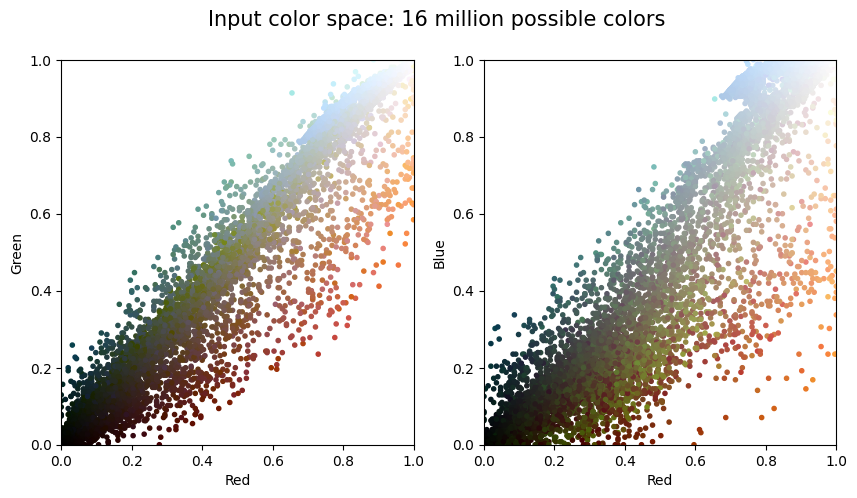

In [15]:
plot_pixels(data, title = 'Input color space: 16 million possible colors')

> Now reduce these 16 Million color to just 16, using a k-means clustering across the pixel space.

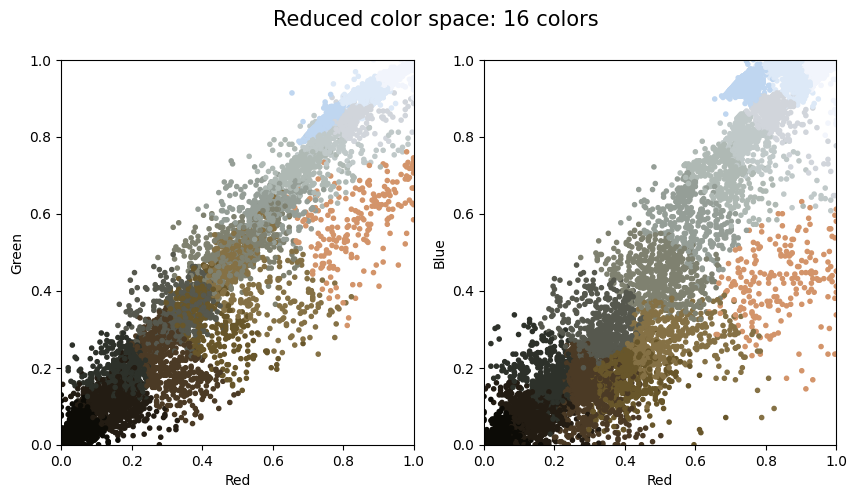

In [23]:
kmeans = KMeans(n_clusters=16).fit(data)
new_colors = kmeans.centers[kmeans.predict(data)]
plot_pixels(data, colors = new_colors, title = 'Reduced color space: 16 colors')

> Show the resulting Image-data with the new colors in the image space.

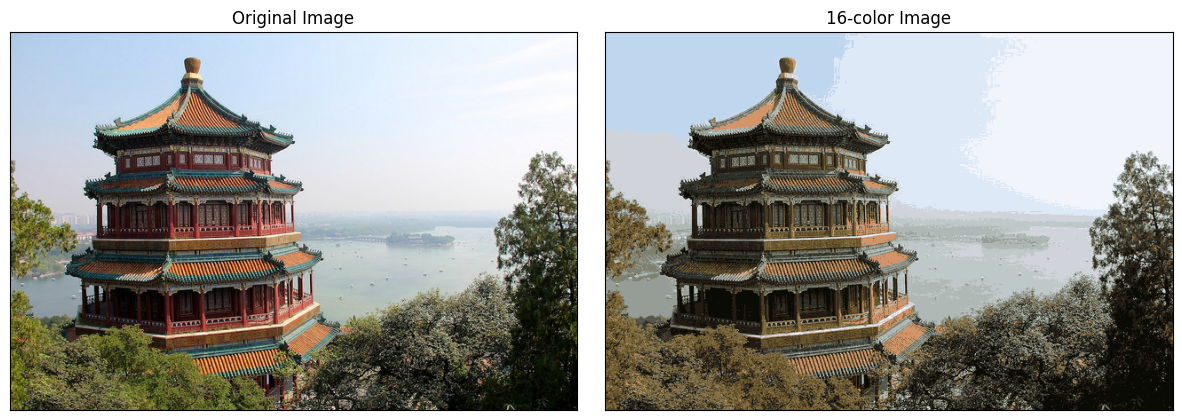

In [24]:
china_recolored=new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize = (15, 10), subplot_kw = dict(xticks = [], yticks = []))
fig.subplots_adjust(wspace = 0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size = 12)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size = 12)
plt.show()